# The Great Grape Data Analysis Tutorial (TGGDAT)

In [1]:
import datetime

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import filtfilt, butter
from scipy import signal

import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
# Matplotlib settings to make the plots look a little nicer.
plt.rcParams['font.size']      = 18
plt.rcParams['font.weight']    = 'bold'
plt.rcParams['axes.grid']      = True
plt.rcParams['axes.xmargin']   = 0
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.figsize'] = (10,6)

# Control maximum number of rows Pandas can show.
pd.set_option('display.max_rows', 100)

# Load Data File and Plot Raw Data

In [3]:
# Load file into dataframe, ignore comment line,s and parse dates
fname = '2021-04-07T000000Z_N0000007_G1_EN91fh_FRQ_WWV10.csv.bz2'
cfreq = 10e6
df    = pd.read_csv(fname, comment = '#', parse_dates=[0])

# Remove the 10 MHz offset from the frequency column.
df['Freq'] = df['Freq']-cfreq

In [4]:
df

,UTC,Freq,Vpk
0,2021-04-07 00:00:00+00:00,-0.305,0.048158
1,2021-04-07 00:00:01+00:00,-0.301,0.047857
2,2021-04-07 00:00:02+00:00,-0.298,0.050586
3,2021-04-07 00:00:03+00:00,-0.292,0.051483
4,2021-04-07 00:00:04+00:00,-0.294,0.051156
...,...,...,...
84367,2021-04-07 23:59:54+00:00,-0.291,0.040265
84368,2021-04-07 23:59:56+00:00,-0.316,0.035974
84369,2021-04-07 23:59:57+00:00,-0.322,0.035156
84370,2021-04-07 23:59:58+00:00,-0.292,0.045633


In [5]:
df.describe()

,Freq,Vpk
count,84372.000000,84372.000000
mean,-0.042405,0.019463
std,0.335099,0.029744
min,-1.650000,0.000282
25%,-0.199000,0.003281
50%,-0.017000,0.008178
75%,0.048000,0.020323
max,1.968000,0.421697


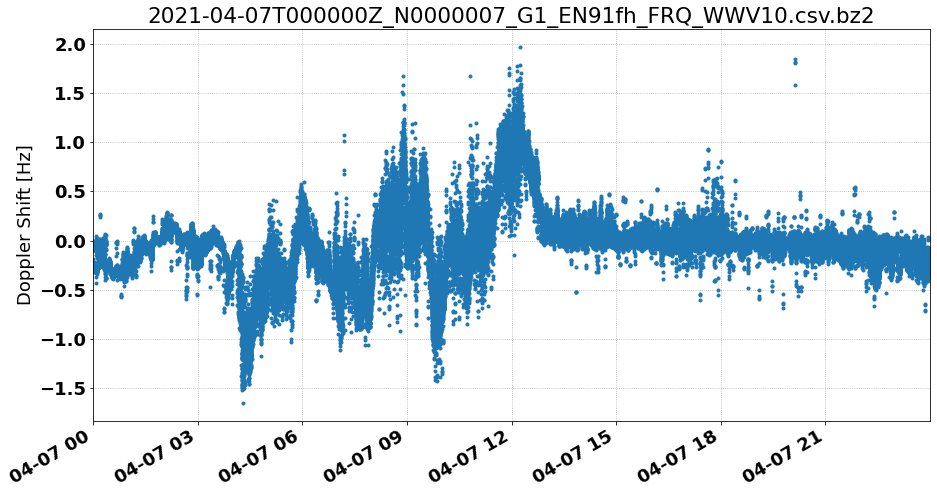

In [6]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)
xx  = df['UTC']
yy  = df['Freq']
ax.plot(xx,yy,ls='',marker='.')
fig.autofmt_xdate()
ax.set_ylabel('Doppler Shift [Hz]')
ax.set_title(fname)
plt.show()

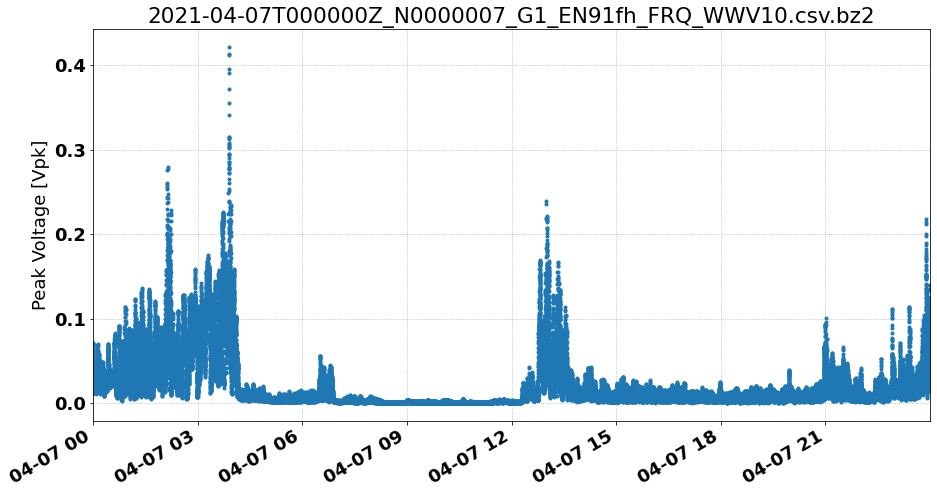

In [7]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)
xx  = df['UTC']
yy  = df['Vpk']
ax.plot(xx,yy,ls='',marker='.')
fig.autofmt_xdate()
ax.set_ylabel('Peak Voltage [Vpk]')
ax.set_title(fname)
plt.show()

# Show Data is Not Regularly Sampled

In [8]:
# Calculate time difference between samples
utcs = [x.to_pydatetime() for x in df['UTC']]
dt   = np.diff(utcs)

# Convert from time delta to total seconds
dt_sec = [x.total_seconds() for x in dt]

In [9]:
# What are the time differences between data points?
# It should only be 1 since the Grape takes 1 measurement every second.
# But, it's not.
unq = np.unique(dt_sec)
unq

array([0., 1., 2., 3.])

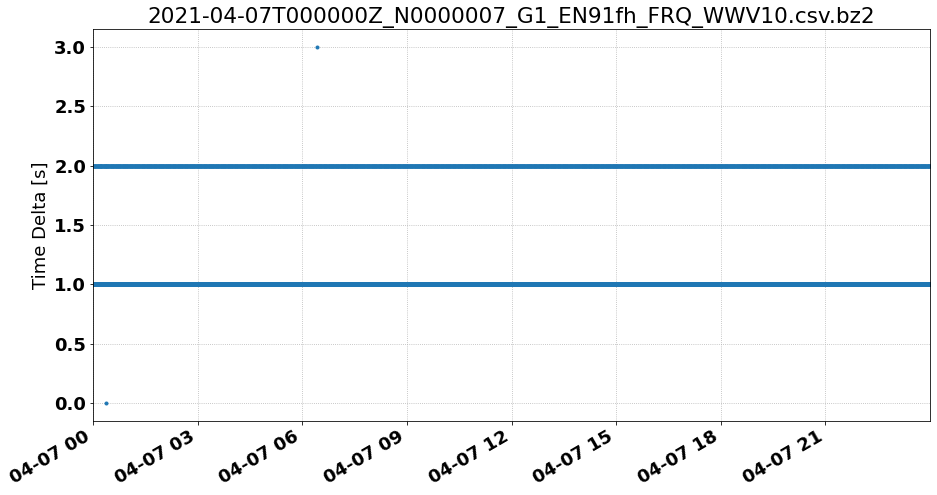

In [10]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)

# np.diff() returns 1 less value than original vector,
# so we need to trim 1 element off of the original vector when plotting
xx  = df['UTC'][:-1]
yy  = dt_sec

ax.plot(xx,yy,ls='',marker='.')
fig.autofmt_xdate()
ax.set_ylabel('Time Delta [s]')
ax.set_title(fname)
plt.show()

# Resample/Interpolate Data to Guarantee Regular Spacing

In [11]:
# Get Julian Dates for Data Frame
jd   = [x.to_julian_date() for x in df['UTC']]

In [12]:
# Create the list of datetimes that we want to resample to.

# Find the start and end times of the array.
sTime = df['UTC'].min()
eTime = df['UTC'].max()

# Break
sYr  = sTime.year
sMon = sTime.month
sDy  = sTime.day
sHr  = sTime.hour
sMin = sTime.minute
sSec = sTime.second
resample_sTime = datetime.datetime(sYr,sMon,sDy,sHr,sMin,sSec)

eYr  = eTime.year
eMon = eTime.month
eDy  = eTime.day
eHr  = eTime.hour
eMin = eTime.minute
eSec = eTime.second
resample_eTime = datetime.datetime(eYr,eMon,eDy,eHr,eMin,eSec)

dt = datetime.timedelta(seconds=1)
rs_times = [resample_sTime]
while rs_times[-1] < resample_eTime:
    rs_times.append(rs_times[-1]+dt)

# Convert to Julian Date
rs_jd   = [x.to_julian_date() for x in pd.to_datetime(rs_times)]

In [13]:
len(rs_jd)

86400

In [14]:
fn      = interp1d(jd,df['Freq'].values)
rs_Freq = fn(rs_jd)
rs_df   = pd.DataFrame({'UTC':rs_times,'Freq':rs_Freq})

In [15]:
rs_df

,UTC,Freq
0,2021-04-07 00:00:00,-0.3050
1,2021-04-07 00:00:01,-0.3010
2,2021-04-07 00:00:02,-0.2980
3,2021-04-07 00:00:03,-0.2920
4,2021-04-07 00:00:04,-0.2940
...,...,...
86395,2021-04-07 23:59:55,-0.3035
86396,2021-04-07 23:59:56,-0.3160
86397,2021-04-07 23:59:57,-0.3220
86398,2021-04-07 23:59:58,-0.2920


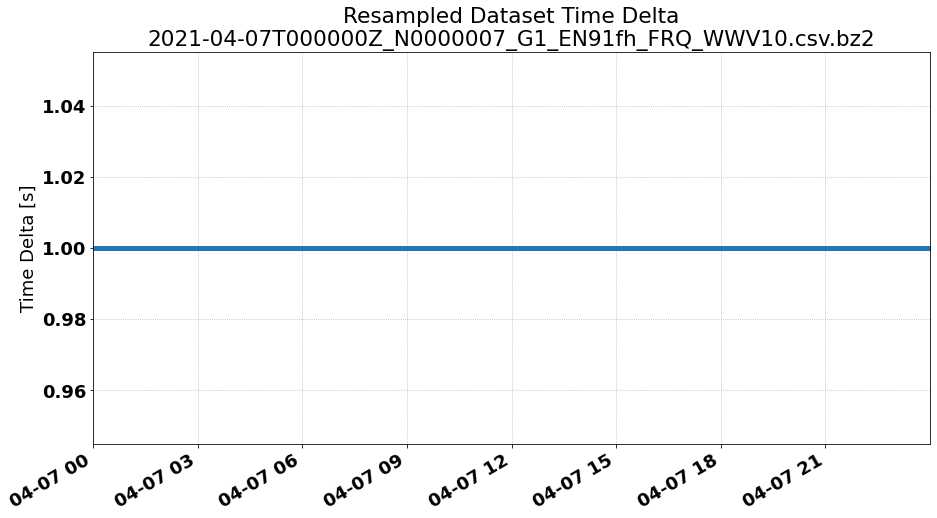

In [16]:
# Calculate time difference between samples
rs_utcs = [x.to_pydatetime() for x in rs_df['UTC']]
rs_dt   = np.diff(rs_utcs)

# Convert from time delta to total seconds
rs_dt_sec = [x.total_seconds() for x in rs_dt]

fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)

# np.diff() returns 1 less value than original vector,
# so we need to trim 1 element off of the original vector when plotting
xx  = rs_df['UTC'][:-1]
yy  = rs_dt_sec

ax.plot(xx,yy,ls='',marker='.')
fig.autofmt_xdate()
ax.set_ylabel('Time Delta [s]')
ax.set_title('Resampled Dataset Time Delta\n'+fname)
plt.show()

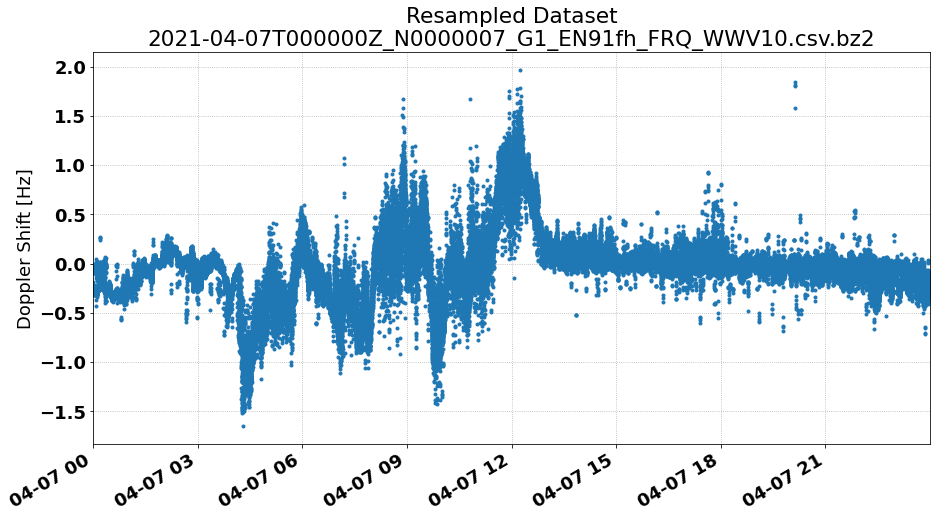

In [17]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)
xx  = rs_df['UTC']
yy  = rs_df['Freq']
ax.plot(xx,yy,ls='',marker='.')
fig.autofmt_xdate()
ax.set_ylabel('Doppler Shift [Hz]')
ax.set_title('Resampled Dataset\n'+fname)
plt.show()

# Apply Default Grape Analysis Filter
This is same filter used to produce the plots that the Grape creates on a nightly basis.

In [18]:
FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
FILTERORDER=6
b, a    = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')
rs_df['Freq_1'] = filtfilt(b, a, rs_df['Freq'])

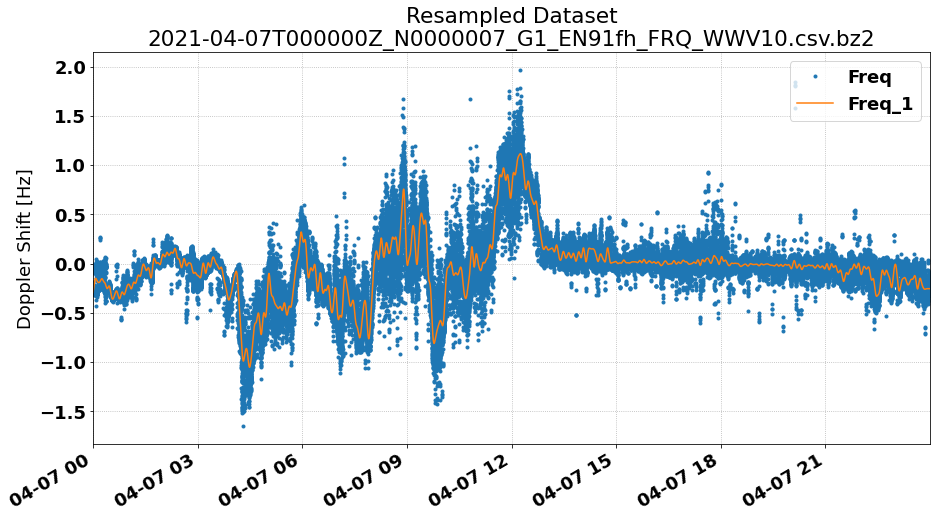

In [19]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)
xx  = rs_df['UTC']
yy  = rs_df['Freq']
ax.plot(xx,yy,ls='',marker='.',label='Freq')

yy  = rs_df['Freq_1']
ax.plot(xx,yy,label='Freq_1')

ax.legend(loc='upper right')

fig.autofmt_xdate()
ax.set_ylabel('Doppler Shift [Hz]')
ax.set_title('Resampled Dataset\n'+fname)
plt.show()

# Compute Spectrogram

/home/w2naf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


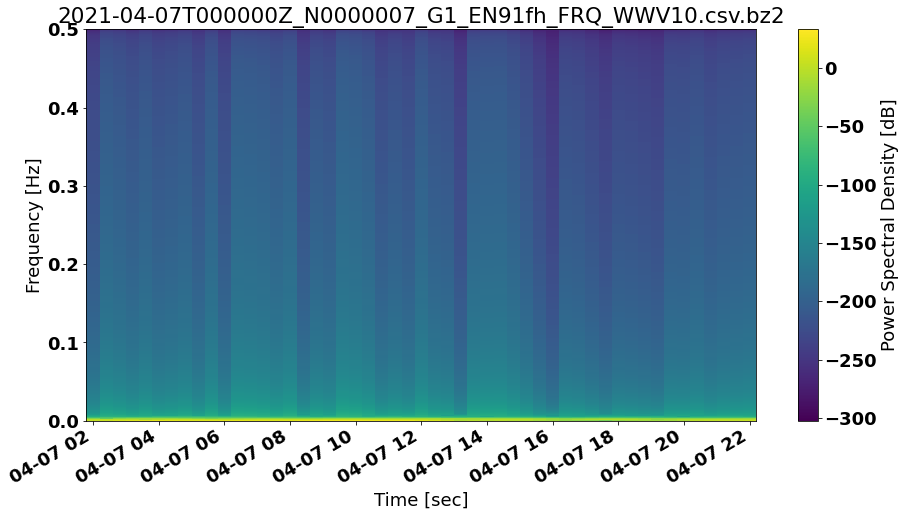

In [20]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(111)

xx  = rs_df['Freq_1']        # Signal
fs  = 1./dt.total_seconds()  # Sampling Frequency

# Number of segments for each window of the FFT.
# Since MSTIDs have a period of 15 to 60 min, a window
# of 4 hr is reasonable since that will let in four full
# periods of 60 min.
nperseg = int((4.*3600.)/dt.total_seconds())
noverlap = int(0.9*nperseg)
f, t, Sxx = signal.spectrogram(xx, fs, nperseg=nperseg, window='hanning',noverlap=noverlap)

# Convert seconds to datetimes.
t_dt = [rs_df['UTC'][0] + datetime.timedelta(seconds=x) for x in t]

ax.grid(False)
mpbl = ax.pcolormesh(t_dt, f, 10.*np.log10(Sxx))
cbar = plt.colorbar(mpbl,label='Power Spectral Density [dB]')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.set_title(fname)

fig.autofmt_xdate()
plt.show()

/home/w2naf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


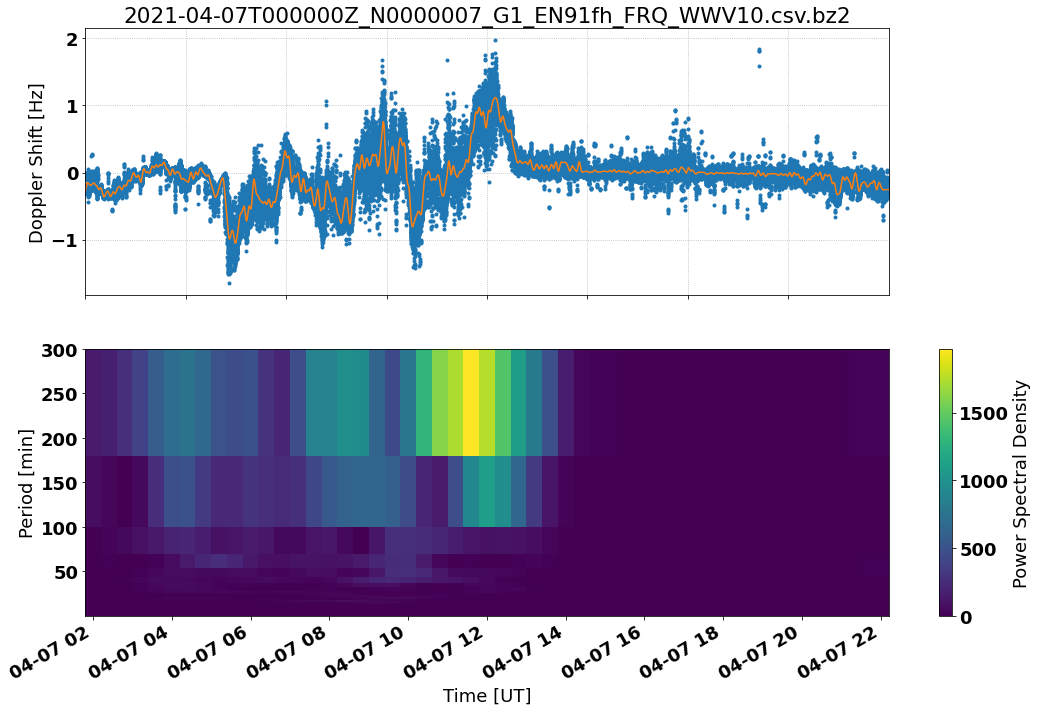

In [21]:
# Remove 0 frequency component.
f_1   = f[1:]
Sxx_1 = Sxx[1:,:]

# Convert f to period in minutes
T_min = 1./(60.*f_1)

# Reverse T vector
T_min  = T_min[::-1]
Sxx_1  = Sxx_1[::-1,:]

fig = plt.figure(figsize=(18,12))

ax_0  = fig.add_subplot(211)
xx    = rs_df['UTC']
yy    = rs_df['Freq']
ax_0.plot(xx,yy,ls='',marker='.',label='Freq')
yy  = rs_df['Freq_1']
ax_0.plot(xx,yy,label='Freq_1')
#ax_0.legend(loc='upper right')
fig.autofmt_xdate()
ax_0.set_ylabel('Doppler Shift [Hz]')
ax_0.set_title(fname)

ax_1  = fig.add_subplot(212)
ax_1.grid(False)
#mpbl = ax_1.pcolormesh(t_dt, T_min, 10.*np.log10(Sxx_1))
mpbl = ax_1.pcolormesh(t_dt, T_min, Sxx_1)
cbar = plt.colorbar(mpbl,label='Power Spectral Density')
ax_1.set_ylabel('Period [min]')
ax_1.set_xlabel('Time [UT]')
#ax_1.set_ylim(0,30)
fig.autofmt_xdate()

ax_0_pos = list(ax_0.get_position().bounds)
ax_1_pos = list(ax_1.get_position().bounds)
ax_0_pos[2] = ax_1_pos[2]
ax_0.set_position(ax_0_pos)

plt.show()

# MSTID Filter

/home/w2naf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


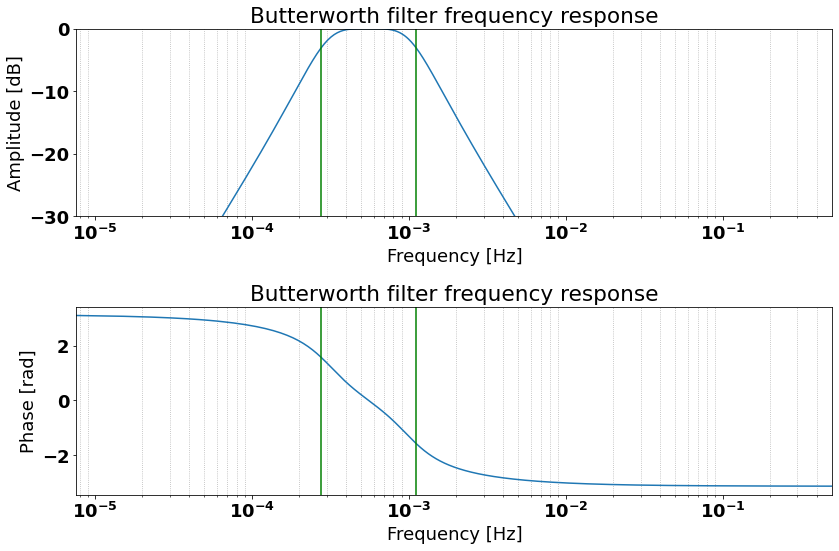

In [22]:
Tc_min = (15, 60)
Wn     = (1./(np.array(Tc_min)*60.))[::-1]

#Wn    = (1000, 5000)    # 3 dB Cutoff Frequency in Hz
btype = 'bandpass'       # Choose 'bandpass' or 'bandstop'

b, a = signal.butter(2, Wn, btype, fs=fs)

rs_df['Freq_2'] = filtfilt(b, a, rs_df['Freq_1'])

w, h = signal.freqz(b, a,worN=2**16)

f = (fs/2)*(w/(np.pi))

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(f, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.axvline(Wn[0], color='green') # cutoff frequency
plt.axvline(Wn[1], color='green') # cutoff frequency

plt.ylim(-30,0)

plt.subplot(212)
plt.plot(f, np.unwrap(np.angle(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [rad]')
plt.grid(which='both', axis='both')
plt.axvline(Wn[0], color='green') # cutoff frequency
plt.axvline(Wn[1], color='green') # cutoff frequency

plt.tight_layout()
plt.show()

/home/w2naf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


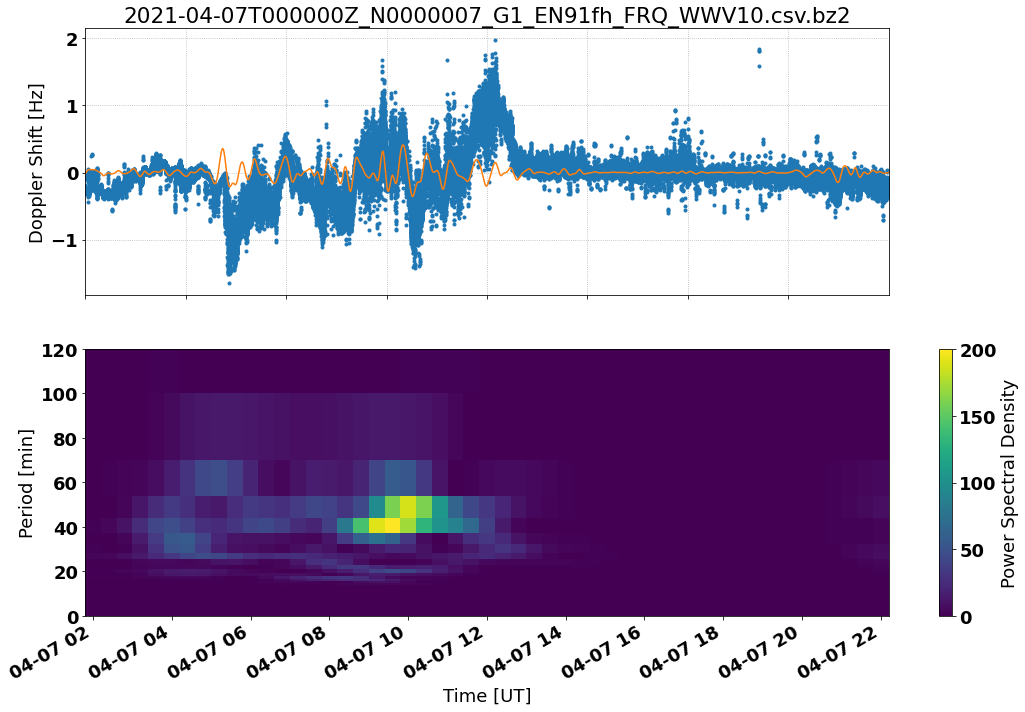

In [23]:
xx  = rs_df['Freq_2']        # Signal
fs  = 1./dt.total_seconds()  # Sampling Frequency

# Number of segments for each window of the FFT.
# Since MSTIDs have a period of 15 to 60 min, a window
# of 4 hr is reasonable since that will let in four full
# periods of 60 min.
nperseg = int((4.*3600.)/dt.total_seconds())
noverlap = int(0.9*nperseg)
f, t, Sxx = signal.spectrogram(xx, fs, nperseg=nperseg, window='hanning',noverlap=noverlap)

# Convert seconds to datetimes.
t_dt = [rs_df['UTC'][0] + datetime.timedelta(seconds=x) for x in t]

# Remove 0 frequency component.
f_1   = f[1:]
Sxx_1 = Sxx[1:,:]

# Convert f to period in minutes
T_min = 1./(60.*f_1)

# Reverse T vector
T_min  = T_min[::-1]
Sxx_1  = Sxx_1[::-1,:]

fig = plt.figure(figsize=(18,12))

ax_0  = fig.add_subplot(211)
xx    = rs_df['UTC']
yy    = rs_df['Freq']
ax_0.plot(xx,yy,ls='',marker='.',label='Freq')
yy  = rs_df['Freq_2']
ax_0.plot(xx,yy,label='Freq_2')
#ax_0.legend(loc='upper right')
fig.autofmt_xdate()
ax_0.set_ylabel('Doppler Shift [Hz]')
ax_0.set_title(fname)

ax_1  = fig.add_subplot(212)
ax_1.grid(False)
mpbl = ax_1.pcolormesh(t_dt, T_min, Sxx_1)
cbar = plt.colorbar(mpbl,label='Power Spectral Density')
ax_1.set_ylabel('Period [min]')
ax_1.set_xlabel('Time [UT]')
ax_1.set_ylim(0,120)
fig.autofmt_xdate()

ax_0_pos = list(ax_0.get_position().bounds)
ax_1_pos = list(ax_1.get_position().bounds)
ax_0_pos[2] = ax_1_pos[2]
ax_0.set_position(ax_0_pos)

plt.show()